In [2]:
from OF_trigger import *
from trace_IO import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sampling_frequency = 3906250
template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)

Processing energies: 100%|██████████| 75/75 [44:36<00:00, 35.69s/it]


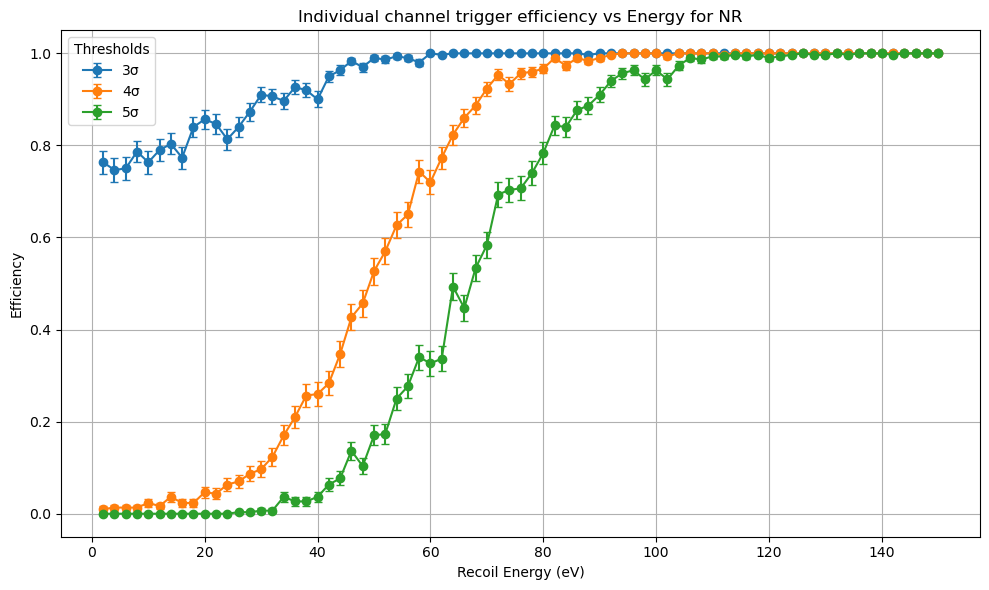

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fixed parameters
sigma = 0.7674  # sigma for the fixed OF ampl distribution with MMC noise traces
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]
energy_values = list(range(2, 151, 2))
n_sets = 300  # Number of sets (trials) per energy

# Containers for results
pass_rates_by_threshold = {th: [] for th in thresholds}
uncertainties_by_threshold = {th: [] for th in thresholds}

# Threshold labels for plotting
sigma_labels = {
    thresholds[0]: '3σ',
    thresholds[1]: '4σ',
    thresholds[2]: '5σ'
}

# Loop over all energies
for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/large_samples/NR/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

    max_amplitudes = []

    for i in range(n_sets):
        amps = [trigger.fit_with_shift(trace)[0] for trace in loaded_traces[i]]
        max_amplitudes.append(np.max(amps))

    max_amplitudes = np.array(max_amplitudes)

    for th in thresholds:
        count_pass = np.sum(max_amplitudes > th)
        pass_rate = count_pass / n_sets
        uncertainty = np.sqrt(pass_rate * (1 - pass_rate) / n_sets)

        pass_rates_by_threshold[th].append(pass_rate)
        uncertainties_by_threshold[th].append(uncertainty)

# Plotting with error bars
plt.figure(figsize=(10, 6))
for th in thresholds:
    plt.errorbar(
        energy_values,
        pass_rates_by_threshold[th],
        yerr=uncertainties_by_threshold[th],
        fmt='-o',
        capsize=3,
        label=sigma_labels[th]
    )

plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Efficiency')
plt.title('Individual channel trigger efficiency vs Energy for NR')
plt.legend(title='Thresholds')
plt.grid(True)
plt.tight_layout()
plt.show()
